In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim: int, num_heads: int):
        super().__init__()
        assert input_dim % num_heads == 0
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads
        self.q_linear = nn.Linear(input_dim, input_dim)
        self.k_linear = nn.Linear(input_dim, input_dim)
        self.v_linear = nn.Linear(input_dim, input_dim)
        self.out = nn.Linear(input_dim, input_dim)

    def forward(self, Q, K, V, mask=None):
        B, L, C = Q.shape
        # linear + split heads
        Q = self.q_linear(Q).view(B, L, self.num_heads, self.dim_per_head).permute(0,2,1,3)
        K = self.k_linear(K).view(B, L, self.num_heads, self.dim_per_head).permute(0,2,1,3)
        V = self.v_linear(V).view(B, L, self.num_heads, self.dim_per_head).permute(0,2,1,3)
        # scaled dot‐prod
        scores = (Q @ K.transpose(-2,-1)) / (self.dim_per_head**0.5)  # [B, h, L, L]
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        weights = torch.softmax(scores, dim=-1)
        attn = (weights @ V)               # [B,h,L,dh]
        attn = attn.permute(0,2,1,3).contiguous().view(B, L, C)
        return self.out(attn)

class FeedForwardNetwork(nn.Module):
    def __init__(self, input_dim: int, ff_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, input_dim)
        )
    def forward(self, x):
        return self.net(x)

class TransformerEncoderCell(nn.Module):
    def __init__(self, dim, heads, ff_dim, dropout):
        super().__init__()
        self.attn = MultiHeadAttention(dim, heads)
        self.norm1 = nn.LayerNorm(dim)
        self.drop1 = nn.Dropout(dropout)
        self.ff   = FeedForwardNetwork(dim, ff_dim)
        self.norm2 = nn.LayerNorm(dim)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        y = self.norm1(x + self.drop1(self.attn(x,x,x,mask)))
        y = self.norm2(y + self.drop2(self.ff(y)))
        return y

class TransformerEncoder(nn.Module):
    def __init__(self, dim, heads, ff_dim, depth, dropout):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderCell(dim, heads, ff_dim, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        inv = torch.pow(10000, -torch.arange(0, dim, 2).float() / dim)
        pe[:, 0::2] = torch.sin(pos * inv)
        pe[:, 1::2] = torch.cos(pos * inv)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [B, L, C]
        return x + self.pe[:, :x.size(1)]

In [2]:
class DepressionDataset(Dataset):
    def __init__(self, df, cat_cols, num_cols, target_col):
        # Ensure target column is treated as categorical and encoded
        all_cat_cols = cat_cols + [target_col] # Include target in categorical processing

        # label encoding categorical
        self.cat_maps = {}
        for c in all_cat_cols: # Iterate through all categorical columns including target
            le = LabelEncoder()
            # Handle potential NaN values by converting to string
            df[c] = le.fit_transform(df[c].astype(str))
            self.cat_maps[c] = le

        # standardize numerical
        scaler = StandardScaler()
        # Apply scaling only to the specified numerical columns
        df[num_cols] = scaler.fit_transform(df[num_cols])

        # Separate features and target after encoding/scaling
        # Remove target column from the features for the model input
        feature_cat_cols = [c for c in all_cat_cols if c != target_col]

        self.X_cat = torch.LongTensor(df[feature_cat_cols].values)
        self.X_num = torch.FloatTensor(df[num_cols].values)
        # The target column is now encoded and can be converted to LongTensor
        self.y     = torch.LongTensor(df[target_col].values)

    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return self.X_cat[i], self.X_num[i], self.y[i]

In [3]:
class TabTransformer(nn.Module):
    def __init__(self, cat_dims, num_dim, embed_dim=32,
                 heads=4, depth=2, ff_dim=64, dropout=0.1):
        super().__init__()
        # categorical embedding
        self.cat_embs = nn.ModuleList([
            nn.Embedding(dim, embed_dim) for dim in cat_dims
        ])
        # numerical feature mapping → embedding
        self.num_lin = nn.Linear(num_dim, embed_dim)
        # positional + transformer
        self.pos_enc = PositionalEncoding(embed_dim, max_len=len(cat_dims)+1)
        self.transf  = TransformerEncoder(embed_dim, heads, ff_dim, depth, dropout)
        # classification head
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )

    def forward(self, x_cat, x_num):
        # x_cat: [B, C], x_num: [B, N]
        emb_cat = [emb(x_cat[:,i]) for i,emb in enumerate(self.cat_embs)]
        emb_num = self.num_lin(x_num).unsqueeze(1)           # [B,1,embed]
        seq = torch.stack(emb_cat, dim=1)                    # [B, C, E]
        seq = torch.cat([seq, emb_num], dim=1)               # [B, C+1, E]
        seq = self.pos_enc(seq)
        seq = self.transf(seq)                               # [B, C+1, E]
        feat = seq.mean(dim=1)                               # [B, E]
        return self.head(feat)

In [4]:
def train_epoch(model, loader, opt, criterion, device):
    model.train()
    total, correct = 0, 0
    for xc, xn, y in loader:
        xc,xn,y = xc.to(device), xn.to(device), y.to(device)
        opt.zero_grad()
        pred = model(xc, xn)
        loss = criterion(pred, y)
        loss.backward()
        opt.step()
        total += y.size(0)
        correct += (pred.argmax(1)==y).sum().item()
    return loss.item(), correct/total

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for xc, xn, y in loader:
            xc,xn,y = xc.to(device), xn.to(device), y.to(device)
            pred = model(xc, xn)
            loss = criterion(pred, y)
            total += y.size(0)
            correct += (pred.argmax(1)==y).sum().item()
    return loss.item(), correct/total

In [5]:
def load_and_preprocess(df, cat_cols, num_cols, target):
    df[cat_cols] = df[cat_cols].fillna('Missing')
    
    for n in num_cols:
        df[f"{n}_missing"] = df[n].isna().astype(int)
        df[n] = df[n].fillna(df[n].mean())
    
    return df

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("final_depression_dataset_1.csv")
# print(df.isna().sum())
target = "Depression"
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c!=target]
num_cols = [c for c in df.columns if c not in cat_cols+[target]]

df = load_and_preprocess(df, cat_cols, num_cols, target)
# Pass the original df and column lists to the dataset
ds = DepressionDataset(df.copy(), cat_cols, num_cols, target) # Use a copy to avoid modifying the original df outside the class if needed later

train_ds, val_ds = train_test_split(ds, test_size=0.2, stratify=ds.y, random_state=42)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=64, shuffle=False)

model = TabTransformer(
    # cat_dims should be based on the actual categorical feature columns, excluding the target
    cat_dims=[len(ds.cat_maps[c].classes_) for c in cat_cols],
    num_dim=len(num_cols),
    embed_dim=32, heads=4, depth=2, ff_dim=64, dropout=0.1
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

best_acc = 0
for epoch in range(1, 31):
    loss_tr, acc_tr = train_epoch(model, train_dl, optimizer, criterion, device)
    loss_va, acc_va = eval_epoch(model, val_dl,   criterion, device)
    print(f"Epoch {epoch:02d} | "
            f"train: loss={loss_tr:.4f}, acc={acc_tr:.4f} | "
            f"val:   loss={loss_va:.4f}, acc={acc_va:.4f}")
    if acc_va > best_acc:
        best_acc = acc_va
        torch.save(model.state_dict(), "best_tabtransformer.pt")
print("Best val accuracy:", best_acc)

Epoch 01 | train: loss=0.5134, acc=0.7432 | val:   loss=0.4888, acc=0.8223
Epoch 02 | train: loss=0.3822, acc=0.8219 | val:   loss=0.4635, acc=0.8223
Epoch 03 | train: loss=0.3833, acc=0.8229 | val:   loss=0.4101, acc=0.8262
Epoch 04 | train: loss=0.3036, acc=0.8503 | val:   loss=0.3825, acc=0.8711
Epoch 05 | train: loss=0.1713, acc=0.8684 | val:   loss=0.3502, acc=0.8906
Epoch 06 | train: loss=0.2052, acc=0.8841 | val:   loss=0.3093, acc=0.8945
Epoch 07 | train: loss=0.2676, acc=0.9041 | val:   loss=0.2769, acc=0.9219
Epoch 08 | train: loss=0.0775, acc=0.9344 | val:   loss=0.1783, acc=0.9297
Epoch 09 | train: loss=0.1118, acc=0.9506 | val:   loss=0.1181, acc=0.9512
Epoch 10 | train: loss=0.1573, acc=0.9599 | val:   loss=0.1064, acc=0.9551
Epoch 11 | train: loss=0.0402, acc=0.9687 | val:   loss=0.1083, acc=0.9570
Epoch 12 | train: loss=0.0603, acc=0.9638 | val:   loss=0.1092, acc=0.9648
Epoch 13 | train: loss=0.0994, acc=0.9736 | val:   loss=0.1050, acc=0.9609
Epoch 14 | train: loss=0.


=== lr=0.001, ff_dim=32 ===
Epoch 01 | train: loss=0.4942, acc=0.8141 | val:   loss=0.4925, acc=0.8223
Epoch 02 | train: loss=0.4841, acc=0.8219 | val:   loss=0.4773, acc=0.8223
Epoch 03 | train: loss=0.3807, acc=0.8219 | val:   loss=0.4478, acc=0.8223
Epoch 04 | train: loss=0.3442, acc=0.8395 | val:   loss=0.4093, acc=0.8711
Epoch 05 | train: loss=0.3018, acc=0.8772 | val:   loss=0.3657, acc=0.8926
Epoch 06 | train: loss=0.2715, acc=0.8963 | val:   loss=0.3231, acc=0.9199
Epoch 07 | train: loss=0.1249, acc=0.9051 | val:   loss=0.2647, acc=0.9199
Epoch 08 | train: loss=0.0967, acc=0.9203 | val:   loss=0.2073, acc=0.9062
Epoch 09 | train: loss=0.1647, acc=0.9388 | val:   loss=0.1356, acc=0.9414
Epoch 10 | train: loss=0.1392, acc=0.9511 | val:   loss=0.0937, acc=0.9531
Epoch 11 | train: loss=0.1685, acc=0.9618 | val:   loss=0.0711, acc=0.9570
Epoch 12 | train: loss=0.0774, acc=0.9653 | val:   loss=0.0690, acc=0.9473
Epoch 13 | train: loss=0.0433, acc=0.9711 | val:   loss=0.0480, acc=0.9

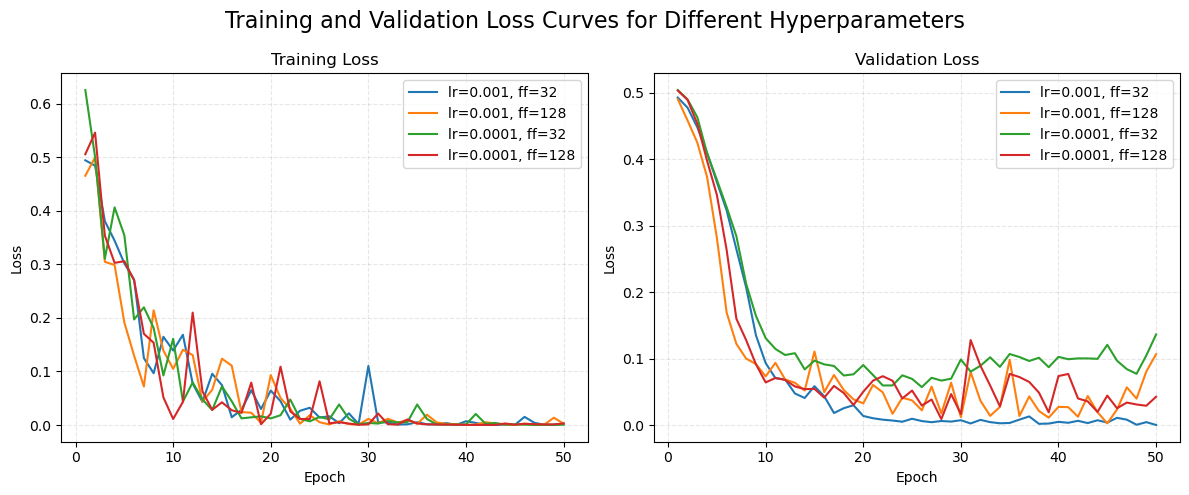

In [7]:
import matplotlib.pyplot as plt
hp_grid = [
        (1e-3, 32),
        (1e-3, 128),
        (1e-4, 32),
        (1e-4, 128),
    ]
train_curves = {}
val_curves   = {}

epochs = 50
for lr, ff_dim in hp_grid:
    print(f"\n=== lr={lr:g}, ff_dim={ff_dim} ===")
    model = TabTransformer(
        cat_dims=[len(ds.cat_maps[c].classes_) for c in cat_cols],
        num_dim=len(num_cols),
        embed_dim=32,
        heads=4,
        depth=2,
        ff_dim=ff_dim,
        dropout=0.1
    ).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses   = []
    best_acc = 0
    for epoch in range(1, epochs + 1):
        loss_tr, acc_tr = train_epoch(model, train_dl, optimizer, criterion, device)
        loss_va, acc_va = eval_epoch(model, val_dl,   criterion, device)
        print(f"Epoch {epoch:02d} | "
              f"train: loss={loss_tr:.4f}, acc={acc_tr:.4f} | "
              f"val:   loss={loss_va:.4f}, acc={acc_va:.4f}")
        train_losses.append(loss_tr)
        val_losses.append(loss_va)
        # if acc_va > best_acc:
        #     best_acc = acc_va
        #     torch.save(model.state_dict(), "best_tabtransformer.pt")
    train_curves[(lr, ff_dim)] = train_losses
    val_curves[(lr, ff_dim)]   = val_losses

plt.figure(figsize=(12,5))
plt.suptitle("Training and Validation Loss Curves for Different Hyperparameters", fontsize=16)
plt.subplot(1,2,1)
for (lr, ff_dim), curve in train_curves.items():
    plt.plot(range(1, epochs+1), curve, label=f"lr={lr:g}, ff={ff_dim}")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3, linestyle="--")

plt.subplot(1,2,2)
for (lr, ff_dim), curve in val_curves.items():
    plt.plot(range(1, epochs+1), curve, label=f"lr={lr:g}, ff={ff_dim}")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()